In [47]:
train_set_pos_path = "E:/Datamining/Data/Training Data/pos/"
train_set_neg_path = "E:/Datamining/Data/Training Data/neg/"

test_set_pos_path = "E:/Datamining/Data/Test Data/pos/"
test_set_neg_path = "E:/Datamining/Data/Test Data/neg/"


In [48]:
def load_file(filepath):
    file = open(filepath, 'r')  # open the file in the read only mode
    text = file.read()          # read the contents of the file
    file.close()                # close the file 
    return text

In [49]:
from nltk.corpus import stopwords
import string

def clean_file(file):
    tokens = file.split()                                 # split into tokens on whitespace
    
    table = str.maketrans('' , '', string.punctuation)    # remove punctuation
    tokens = [w.translate(table) for w in tokens]
    
    tokens = [word for word in tokens if word.isalpha()]  # remove non-alphabetic tokens
    
    set_of_stop_words = set(stopwords.words('english'))   # remove stop words
    tokens = [word for word in tokens if not word in set_of_stop_words]
    
    tokens = [word for word in tokens if len(word) > 1]   # remove tokens of length <= 1
    
    return tokens

In [50]:
# an example to understand the effects of load_file and clean_file methods

filename = 'E:/Datamining/Data/Training Data/pos/cv034_29647.txt'
text = load_file(filename)
tokens = clean_file(text)

print("\n************************************************PRE CLEANING(ORIGINAL TEXT)**********************************************\n")
print(text)
print("*************************************************POST CLEANING(TOKENS)***************************************************\n")
print(tokens)
print("*************************************************************************************************************************\n")


************************************************PRE CLEANING(ORIGINAL TEXT)**********************************************

plot : derek zoolander is a male model . 
he is also very dumb and impressionable . 
for that reason , he is secretly hired and trained ( so secret , that even he doesn't know about it ) by an underground fashion syndicate to assassinate the prime minister of malaysia , who wants to abolish child labor in his country . 
will zoolander fulfill the dirty deed ? 
will zoolander ever grace the world his new " look " ? 
is this a funny movie ? 
find out below . . . 
critique : there's a place in our world for " stupid comedies " . 
films which don't pretend to take themselves seriously , are based on idiotic premises and filled with dumb jokes . 
there's also a time for them and many would argue that this difficult period of our history , might be an ideal circumstance during which to " relax " by watching something so completely frivolous . 
well , if you're in the mo

In [51]:
from os import listdir
from collections import Counter

def add_words_to_vocab_and_update_count(directory, vocab):
    for filename in listdir(directory):
        filepath = directory + '/' + filename
        text = load_file(filepath)  # load the file
        tokens = clean_file(text)   # clean the file
        vocab.update(tokens)        # update count of the word in the vocab
    
vocab = Counter()   # to hold tokens and their respective counts. Eg: [('tok1',tok1_count), ('tok2',tok2_count),...]

add_words_to_vocab_and_update_count('E:/Datamining/Data/Training Data/pos', vocab)
add_words_to_vocab_and_update_count('E:/Datamining/Data/Training Data/neg', vocab)

print('The length of the vocab: ',len(vocab))
print('\nTop 10 frequently occuring words:',vocab.most_common(10))

The length of the vocab:  44276

Top 10 frequently occuring words: [('film', 7983), ('one', 4946), ('movie', 4826), ('like', 3201), ('even', 2262), ('good', 2080), ('time', 2041), ('story', 1907), ('films', 1873), ('would', 1844)]


In [52]:
min_occurrence = 2

print('Total Tokens (Before): ',len(vocab))
tokens = [token for token,count in vocab.items() if count >= min_occurrence]    # list of tokens with count >= 2
print('Total Tokens (After) : ',len(tokens))


Total Tokens (Before):  44276
Total Tokens (After) :  25767


In [53]:
def save_list(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_list(tokens, 'vocab.txt')   # the vocabulary is saved in a text file for later use

In [54]:
def reviews_to_lines(directory, vocab):
    lines = []
    for filename in listdir(directory):
        filepath = directory + filename
        text = load_file(filepath)  # load the file
        tokens = clean_file(text)   # clean the file
        tokens = [word for word in tokens if word in vocab]   # filter by vocab
        line = ' '.join(tokens)     # single review -> tokens -> filter -> single line with tokens spaced by whitespace
        lines.append(line)          # list of reviews. Single review is stored at each index of the list
    return lines

# load the vocabulary
vocab = load_file("vocab.txt")
vocab = vocab.split()
vocab = set(vocab)

# Training Data : reviews to lines
train_pos_reviews_to_lines = reviews_to_lines(train_set_pos_path, vocab)
train_neg_reviews_to_lines = reviews_to_lines(train_set_neg_path, vocab)

# Test Data : reviews to lines
test_pos_reviews_to_lines = reviews_to_lines(test_set_pos_path, vocab)
test_neg_reviews_to_lines = reviews_to_lines(test_set_neg_path, vocab)

# Total training and testing data
train_reviews = train_pos_reviews_to_lines + train_neg_reviews_to_lines
test_reviews  = test_pos_reviews_to_lines  + test_neg_reviews_to_lines

In [55]:
from keras.preprocessing.text import Tokenizer

def prepare_data(train_reviews, test_reviews, mode):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_reviews) # fit the tokenizer on the texts

    xtrain = tokenizer.texts_to_matrix(train_reviews, mode = mode)  # encode the training set
    xtest  = tokenizer.texts_to_matrix(test_reviews, mode = mode)   # encode the test set

    return xtrain, xtest

xtrain, xtest = prepare_data(train_reviews, test_reviews, mode = 'freq')

print(" Shape of xtrain: ", xtrain.shape)
print(" Shape of xtest : ", xtest.shape)

 Shape of xtrain:  (1800, 25768)
 Shape of xtest :  (200, 25768)


In [56]:
import numpy as np

train_pos_limit = int(xtrain.shape[0]/2) # upper limit of pos training reviews
train_neg_limit = xtrain.shape[0]        # upper limit of neg training reviews
test_pos_limit  = int(xtest.shape[0]/2)  # upper limit of pos test reviews
test_neg_limit  = xtest.shape[0]         # upper limit of neg test reviews 

ytrain = np.array([0 for i in range(0, train_pos_limit)] + [1 for i in range(train_pos_limit, train_neg_limit)])
ytest  = np.array([0 for i in range(0, test_pos_limit)]  + [1 for i in range(test_pos_limit, test_neg_limit)])


In [57]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

def seniment_analysis_model(xtrain, ytrain):
    n_words = xtrain.shape[1]  
    # define the network
    model = Sequential()
    model.add(Dense(50, input_shape = (n_words, ), activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    # compile the network
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    # fit the network to the training data
    history = model.fit(xtrain, ytrain, epochs = 25, verbose = 2)
    
    return model, history

classifier, model_history = seniment_analysis_model(xtrain, ytrain)

Epoch 1/25
 - 2s - loss: 0.6927 - accuracy: 0.4967
Epoch 2/25
 - 2s - loss: 0.6890 - accuracy: 0.5583
Epoch 3/25
 - 2s - loss: 0.6791 - accuracy: 0.7961
Epoch 4/25
 - 2s - loss: 0.6628 - accuracy: 0.7172
Epoch 5/25
 - 2s - loss: 0.6364 - accuracy: 0.9022
Epoch 6/25
 - 2s - loss: 0.6037 - accuracy: 0.9289
Epoch 7/25
 - 2s - loss: 0.5682 - accuracy: 0.9361
Epoch 8/25
 - 2s - loss: 0.5296 - accuracy: 0.9461
Epoch 9/25
 - 2s - loss: 0.4906 - accuracy: 0.9517
Epoch 10/25
 - 2s - loss: 0.4522 - accuracy: 0.9578
Epoch 11/25
 - 2s - loss: 0.4162 - accuracy: 0.9622
Epoch 12/25
 - 2s - loss: 0.3814 - accuracy: 0.9661
Epoch 13/25
 - 2s - loss: 0.3498 - accuracy: 0.9722
Epoch 14/25
 - 2s - loss: 0.3200 - accuracy: 0.9794
Epoch 15/25
 - 2s - loss: 0.2929 - accuracy: 0.9800
Epoch 16/25
 - 2s - loss: 0.2693 - accuracy: 0.9828
Epoch 17/25
 - 2s - loss: 0.2461 - accuracy: 0.9856
Epoch 18/25
 - 2s - loss: 0.2259 - accuracy: 0.9878
Epoch 19/25
 - 2s - loss: 0.2077 - accuracy: 0.9889
Epoch 20/25
 - 2s - l

In [58]:
loss, accuracy = classifier.evaluate(xtest, ytest, verbose = 0)
print('Test accuracy = ', (accuracy * 100))

Test accuracy =  89.99999761581421


In [59]:
model_history.history.keys()

dict_keys(['loss', 'accuracy'])

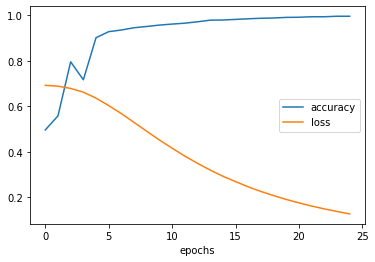

In [60]:
# plot for visulizing how the loss and accuracy changes with each epoch of training

import matplotlib.pyplot as plt
%matplotlib inline


plt.plot(model_history.history['accuracy'], label = 'accuracy')
plt.plot( model_history.history['loss'], label = 'loss')
plt.xlabel('epochs')
plt.legend(loc = 'center right')